## Storing various files data for Synchronization

In [1]:
import pandas as pd
import csv

# Load the CSV file for GNSS data
gnss_file_path = '/Users/ravitejakunchanapalli/Downloads/baleno_data/bestpos.csv'
gnss_data = pd.read_csv(gnss_file_path, delimiter=',')  # Use comma as delimiter if that's correct

# Extract the 'time', 'lat', and 'lon' columns from GNSS data
gnss_time = gnss_data['time'].tolist()
latitudes = gnss_data['.lat'].tolist()
longitudes = gnss_data['.lon'].tolist()

# Create a DataFrame for GNSS data
gnss_df = pd.DataFrame({
    'time': gnss_time,
    'latitude': latitudes,
    'longitude': longitudes
})

# Load the CSV file for BestVel data
bestvel_file_path = '/Users/ravitejakunchanapalli/Downloads/baleno_data/bestvel.csv'
bestvel_data = pd.read_csv(bestvel_file_path, delimiter=',')  # Use comma as delimiter if that's correct

# Extract the 'time' and 'hor_speed' columns from BestVel data
bestvel_time = bestvel_data['time'].tolist()
hori_speed = bestvel_data['.hor_speed'].tolist()
print(hori_speed[:10])

# Multiply each value in hori_speed by 3.6
horizontal_speed = [speed * 3.6 for speed in hori_speed]
print(horizontal_speed[:10])

# Create a DataFrame for BestVel data
bestvel_df = pd.DataFrame({
    'time': bestvel_time,
    'horizontal_speed': horizontal_speed
})

# Load the CSV file for Basler data
basler_file_path = '/Users/ravitejakunchanapalli/Downloads/baleno_data/basler.csv'

# List to store the extracted Basler time values
basler_time = []

# Read the Basler CSV file line by line and extract the 'time' column, skipping the first line
with open(basler_file_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the first line
    for row in reader:
        if row:
            fields = row[0].split(',')
            time_value = fields[0].strip()
            basler_time.append(time_value)

# Create a DataFrame for Basler data with specified column name
basler_df = pd.DataFrame({
    'time': basler_time
})

# Save the dataframes to CSV files
gnss_df.to_csv('/Users/ravitejakunchanapalli/Downloads/baleno_data/gnss_data.csv', index=False)
bestvel_df.to_csv('/Users/ravitejakunchanapalli/Downloads/baleno_data/bestvel_data.csv', index=False)
basler_df.to_csv('/Users/ravitejakunchanapalli/Downloads/baleno_data/basler_data.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ravitejakunchanapalli/Downloads/baleno_data/bestpos.csv'

# Images Fitting  code

len 806
                        time  horizontal_speed   latitude  longitude  \
0 2024-05-31 15:53:13.260321          0.396750  17.601456  78.126582   
1 2024-05-31 15:53:13.360199          0.399396  17.601456  78.126582   
2 2024-05-31 15:53:13.472215          0.406069  17.601456  78.126582   
3 2024-05-31 15:53:13.560603          0.412153  17.601456  78.126582   
4 2024-05-31 15:53:13.660611          0.416100  17.601456  78.126582   

                         image_filename  
0  image_2024-05-31-15-53-13.299873.jpg  
1  image_2024-05-31-15-53-13.370764.jpg  
2  image_2024-05-31-15-53-13.448701.jpg  
3  image_2024-05-31-15-53-13.595876.jpg  
4  image_2024-05-31-15-53-13.666944.jpg  
Map saved to /Users/ravitejakunchanapalli/Desktop/img_test6.html
Color bar saved to /Users/ravitejakunchanapalli/Desktop/colorbar6.png


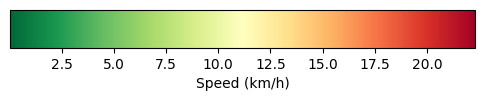

In [32]:
import pandas as pd
import folium
import os
from matplotlib import cm, colors
import matplotlib.pyplot as plt

# Load the GNSS data
gnss_file_path = '/Users/ravitejakunchanapalli/Downloads/baleno_data/gnss_data.csv'
gnss_df = pd.read_csv(gnss_file_path)
gnss_df['time'] = pd.to_datetime(gnss_df['time'])

# Load the BestVel data
bestvel_file_path = '/Users/ravitejakunchanapalli/Downloads/baleno_data/bestvel_data.csv'
bestvel_df = pd.read_csv(bestvel_file_path)
bestvel_df['time'] = pd.to_datetime(bestvel_df['time'])

# Load the Basler data
basler_file_path = '/Users/ravitejakunchanapalli/Downloads/baleno_data/basler_data.csv'
basler_df = pd.read_csv(basler_file_path)
basler_df['time'] = pd.to_datetime(basler_df['time'])

# Merge Basler data with GNSS data based on nearest timestamp from GNSS data
merged_data = pd.merge_asof(gnss_df, basler_df, on='time')

# Merge with BestVel data based on nearest timestamp from BestVel data
merged_data = pd.merge_asof(bestvel_df, merged_data, on='time')

# Directory containing images
image_dir = '/Users/ravitejakunchanapalli/Downloads/baleno_images'

# Function to get image filename based on time
def get_nearest_image(time):
    image_timestamps = pd.to_datetime(os.listdir(image_dir), format='image_%Y-%m-%d-%H-%M-%S.%f.jpg')
    nearest_image = min(image_timestamps, key=lambda x: abs(x - time))
    return f'image_{nearest_image.strftime("%Y-%m-%d-%H-%M-%S.%f")}.jpg'

# Attach nearest image filename to merged data
merged_data['image_filename'] = merged_data['time'].apply(get_nearest_image)

print("len",len(merged_data))
print(merged_data.head())
# Normalize speed data for color mapping
norm = colors.Normalize(vmin=merged_data['horizontal_speed'].min(), vmax=merged_data['horizontal_speed'].max())
cmap = plt.get_cmap('RdYlGn_r')

# Create the map
m = folium.Map(
    location=[merged_data['latitude'].mean(), merged_data['longitude'].mean()],
    zoom_start=18,
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google'
)

# Add points to the map with color-coded markers and popups based on speed
for _, row in merged_data.iterrows():
    color = colors.rgb2hex(cmap(norm(row['horizontal_speed'])))
    popup_text = f"Latitude: {row['latitude']:.6f}<br>Longitude: {row['longitude']:.6f}<br>Speed: {row['horizontal_speed']:.2f}"
    image_path = os.path.join(image_dir, row['image_filename'])
    if os.path.exists(image_path):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_text + f"<br><img src='{image_path}' width='200'>", max_width=300)
        ).add_to(m)
    else:
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=200)
        ).add_to(m)

# Save the map as an HTML file
map_path = '/Users/ravitejakunchanapalli/Desktop/img_test6.html'
m.save(map_path)
print(f'Map saved to {map_path}')
# Create a color bar and save as an image
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
cbar.set_label('Speed (km/h)')

colorbar_path = '/Users/ravitejakunchanapalli/Desktop/colorbar6.png'
plt.savefig(colorbar_path)
print(f'Color bar saved to {colorbar_path}')

